# Exercise 1.1

## 1.1 a

As $\varepsilon$ follows the normal distribution, the conditional distribution of y given x is:

$$
y \mid x \sim \mathcal{N} \left( \theta_0 + \theta_1 x + \dots + \theta_P x^P, \sigma^2 \right)
$$

The probability density function (PDF) for a normal distribution is:

$$
p(y \mid x, \theta, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(y - \mu(x))^2}{2\sigma^2} \right)
$$

Where $\mu(x)$ is the predicted value:

$$
\mu(x) = \theta_0 + \theta_1 x + \dots + \theta_P x^P.
$$

Given N independent observations $\mathbf{y} = (y_1, y_2, \dots, y_N)^T$, the likelihood function is:

$$
L(\theta, \sigma^2) = \prod_{i=1}^{N} p(y_i \mid x_i, \theta, \sigma^2)
$$

Substituting the normal PDF:

$$
L(\theta, \sigma^2) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(y_i - \mu(x_i))^2}{2\sigma^2} \right)
$$

Taking the natural logarithm:

$$
\log L(\theta, \sigma^2) = \sum_{i=1}^{N} \left[ -\frac{1}{2} \log (2\pi\sigma^2) - \frac{(y_i - \mu(x_i))^2}{2\sigma^2} \right]
$$

Simplifying:

$$
\log L(\theta, \sigma^2) = -\frac{N}{2} \log (2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{N} (y_i - \mu(x_i))^2
$$

Where

$$
\mu(x_i) = \theta_0 + \theta_1 x_i + \dots + \theta_P x_i^P.
$$

## 1.1 b 

To find the maximum likelihood estimates, we differentiate the log-likelihood with respect to each parameter $\theta_j$ and set the derivative equal to zero:

$$
\frac{\partial}{\partial \theta_j}\log L(\theta, \sigma^2) = 0
$$

We have:

$$
\frac{\partial}{\partial \theta_j}\left[ -\frac{1}{2\sigma^2}\sum_{i=1}^{N}(y_i - \mu(x_i))^2 \right] = 0
$$

Carrying out this differentiation explicitly, we get:

$$
\frac{1}{\sigma^2}\sum_{i=1}^{N}(y_i - \mu(x_i)) x_i^j = 0
$$

Since  $\sigma^2$ is positive and nonzero, we simplify to:

$$
\sum_{i=1}^{N}(y_i - \mu(x_i)) x_i^j = 0 \quad \text{for each } j=0,1,...,P
$$

This results in the linear system of equations (normal equations):

$$
\sum_{i=1}^{N}\left(y_i - (\theta_0 + \theta_1 x_i + \dots + \theta_P x_i^P)\right)x_i^j = 0 \quad \text{for each } j=0,1,\dots,P.
$$

In matrix form, this solution can be expressed as:

$$
\hat{\theta} = (X^TX)^{-1}X^Ty
$$

where $X$ is the design matrix containing the polynomial terms.



## 1.1 c 

In [ ]:
# Import Julia packages which will be used later
import Pkg
Pkg.add("Plots")
Pkg.add("Random")
Pkg.add("Optim")
Pkg.add("LinearAlgebra")

In [ ]:
using Random
using Plots

theta_0 = 0.3
theta_1 = -0.1
theta_2 = 0.5
variance = 0.0001
standard_deviation = sqrt(variance)

function get_y_for_noisy_x(start, step, stop, seed)
    x = start:step:stop
    Random.seed!(seed)
    epsilon = randn(length(x))
    y = theta_0 .+ theta_1*x .+ theta_2*x.^2 .+ standard_deviation*epsilon
    return x, y
end

x, y = get_y_for_noisy_x(-0.5, 0.1, 0.2, 42)

scatter(x, y, label="data", xlabel="x", ylabel="y", title="Data")

## 1.1 d

In [ ]:
# Helper function: create design matrix for polynomial of order P
function design_matrix(xvals, P)
    # X will have columns [1, x, x^2, ..., x^P]
    X = [xi^p for xi in xvals, p in 0:P]
    return X
end

# Compute ML estimate \hat{theta} via normal equations and log-likelihood
function ml_estimate(xvals, yvals, P)
    X = design_matrix(xvals, P)
    # ML parameter estimate using least squares
    theta_hat = (X'X) \ (X'yvals)

    # Fitted values
    y_hat = X * theta_hat

    # Residual sum of squares (RSS)
    rss = sum((yvals .- y_hat).^2)

    # Estimate of sigma^2 is RSS / N in the ML setting
    sigma2_hat = rss / length(yvals)

    # Log-likelihood under Gaussian noise
    # L = -N/2 * log(2πσ_hat^2) - RSS/(2σ_hat^2)
    N = length(yvals)
    logL = -N/2 * log(2*π*sigma2_hat) - (rss / (2*sigma2_hat))

    return theta_hat, logL
end

# compute estimates and log-likelihoods for P=1, P=2, P=7
P_values = [1, 2, 7]
estimates = [ml_estimate(x, y, P) for P in P_values]

# print the estimates and log-likelihoods for each P value
for (P, (theta_hat, logL)) in zip(P_values, estimates)
    println("P = $P: \n theta_hat = $theta_hat, \n logL = $logL")
end

The first three parameters of $\theta$ are closest to their true values when the number of parameters is the same as in the original function. The function with only 2 parameters is underfitting and the function with 7 parameters is overfitting.

The log-likelihood is increasing with the number of parameters. This is an indicator that, for noisy data, if the data is too likely to have been generated by the model, the model is likely overfitting.

## 1.1 e

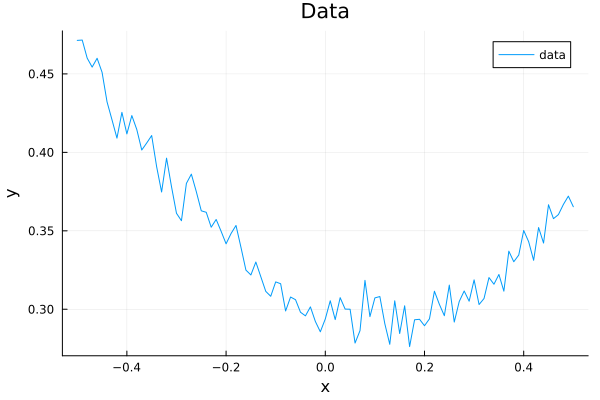

In [70]:
x_new, y_new = get_y_for_noisy_x(-0.5, 0.01, 0.5, 42)

plot(x_new, y_new, label="data", xlabel="x", ylabel="y", title="Data")

In [ ]:
# calculate the log-likelihood for the new data under the ML parameter estimates obtained in (d) for P = 1,2 and 7
function log_likelihood_for_specific_params(xvals, yvals, theta_hat)
    P = length(theta_hat) - 1
    N = length(yvals)
    # estimates
    y_hat = design_matrix(xvals, P) * theta_hat

    # RSS
    rss = sum((yvals .- y_hat).^2)

    # sigma^2
    sigma2_hat = rss / N
    
    # log-likelihood
    logL = -N/2 * log(2*π*sigma2_hat) - (rss / (2*sigma2_hat))

    return logL
end

for (P, (theta_hat, logL)) in zip(P_values, estimates)
    println("P = $P: \n logL = $(log_likelihood_for_specific_params(x_new, y_new, theta_hat))")
end

Fitting the previous parameters to a wider range on the x-axis and a smaller step size one can observe the generelisability of the different models. The model with P=2 is not by far the most likely to have generated the data. P=7, which fit the noise quite well on a shorter scale is now a fairly bad model because outside the range of the previous data it deviates significantly from the original quadratic function. 

Plotting the graphs of the different fits and the newly generated data this can be seen fairly easily:

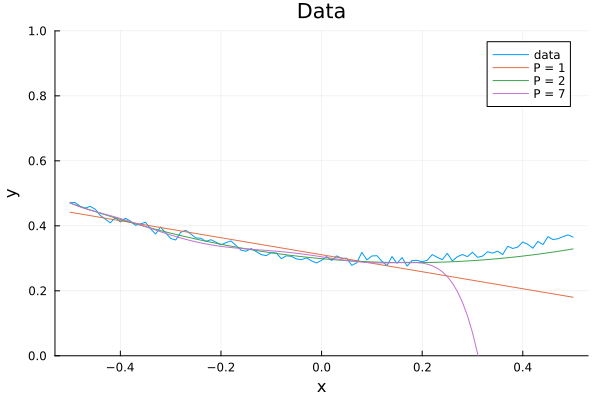

In [72]:
# plot the data and each of the fitted polynomials, keep the y-axis at 0 - 1
plot(x_new, y_new, label="data", xlabel="x", ylabel="y", title="Data", ylims=(0, 1))
for (P, (theta_hat, logL)) in zip(P_values, estimates)
    y_hat = design_matrix(x_new, P) * theta_hat
    plot!(x_new, y_hat, label="P = $P")
end
plot!()

# 1.1 f

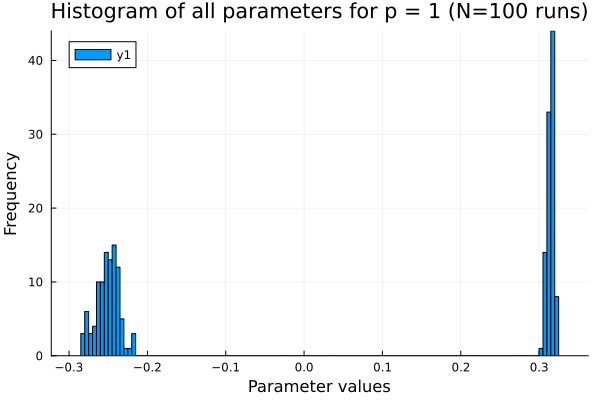

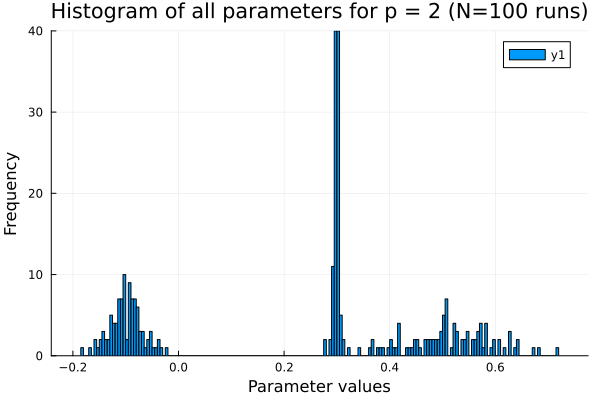

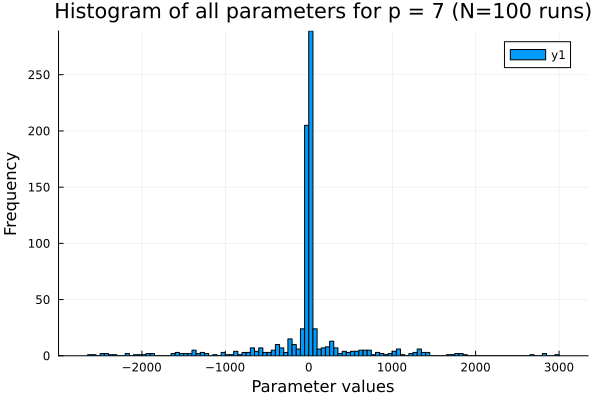

In [73]:
using Plots

N = 100
pvals = [1, 2, 7]
theta_estimates = Dict(p => [] for p in pvals)

# 1) Generate data & collect ML-estimated parameters over repeated runs
for i in 1:N
    # Get a new dataset
    x, y = get_y_for_noisy_x(-0.5, 0.1, 0.2, i)
    
    # Fit each polynomial degree and store the parameter vector
    for p in pvals
        θ̂ = ml_estimate(x, y, p)[1]  # returns a vector of length (p+1)
        push!(theta_estimates[p], θ̂)
    end
end

# 2) For each polynomial order p, flatten ALL parameters into one big vector
#    and draw a single histogram of these values.
for p in pvals
    # theta_estimates[p] is a Vector-of-Vectors:
    #   [ [θ̂_0, θ̂_1, ...], [θ̂_0, θ̂_1, ...], ... ]
    # We'll flatten (vcat) them to one 1D array of length N*(p+1).
    all_params = vcat(theta_estimates[p]...)  

    histogram(
        all_params,
        bins=200,
        title="Histogram of all parameters for p = $p (N=$N runs)",
        xlabel="Parameter values",
        ylabel="Frequency"
    )
    display(current())
end

P=1 and P=2 show quite clearly the distributions for their parameters. P=7 has a very wide range of parameter values and mostly no clear collection of parameter values that belong to a specific parameter. Let's look at the distribution of each parameter separately:

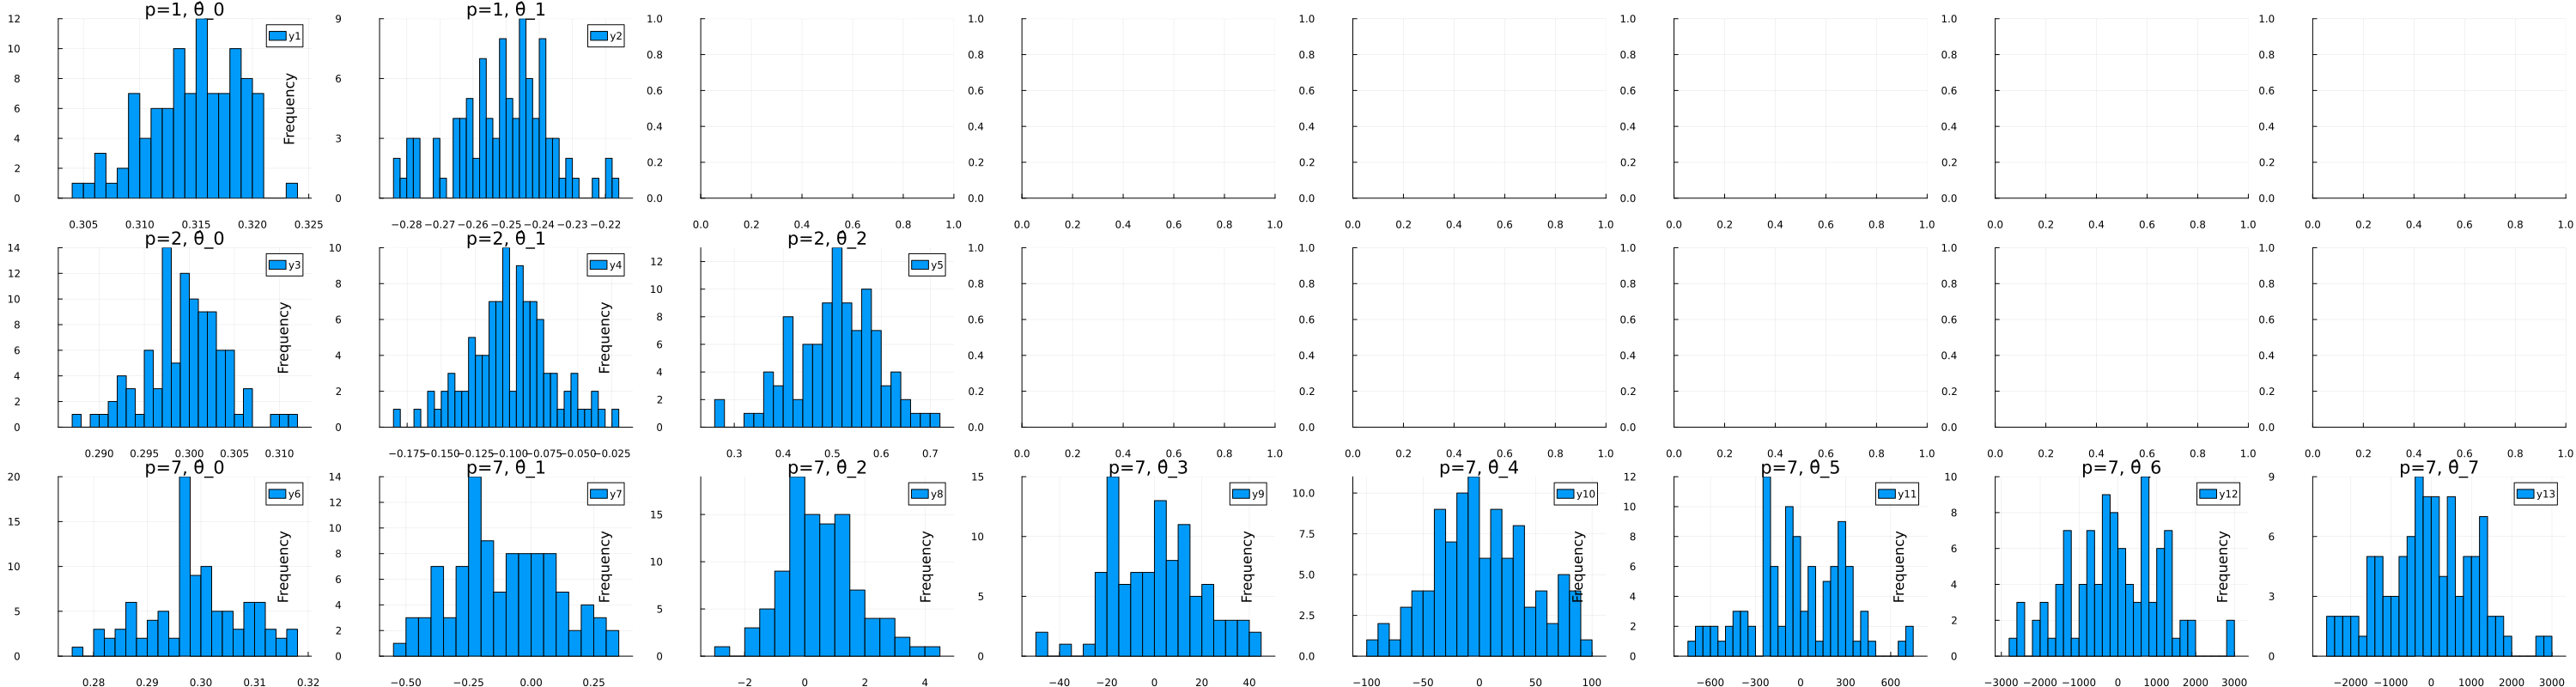

In [74]:
nrows = length(pvals)
ncols = maximum(pvals) + 1  # because p=7 => 8 parameters at most
plt = plot(layout=(nrows, ncols), size=(3000, 800))

for (row_idx, p) in enumerate(pvals)
    # parameter vectors for all runs, e.g. p+1 = number of parameters
    runs = theta_estimates[p]
    for j in 1:(p+1)
        # Column index j for the subplot
        col_idx = j  
        # Extract j-th parameter from each run
        param_vals = [runs[i][j] for i in 1:N]

        # Choose which subplot we draw into
        plot_idx = (row_idx - 1) * ncols + j
        histogram!(
            param_vals,
            subplot=plot_idx,
            bins=30,
            title="p=$p, θ̂_$(j-1)",  # j-1 so indexing matches usual 0..p
            xlabel="Param value",
            ylabel="Frequency"
        )
    end
end

display(plt)

The larger the number of parameters gets, the less consistent the parameters are. E.g. y12 and y13 have a range of about 5000 while y3 and y4 have a range < 0.2.
However, the first three parameters are quite consistent in their distribution regardless of how many parameters come afterwards.

# Exercise 1.2

## 1.2 a

By Bayes' theorem, the posterior distribution of the parameters is given by:

$$
p(\boldsymbol{\theta} | \mathbf{y}) = \frac{p(\mathbf{y} | \boldsymbol{\theta}) p(\boldsymbol{\theta})}{p(\mathbf{y})}
$$

Taking the logarithm:

$$
\log p(\boldsymbol{\theta} | \mathbf{y}) = \log p(\mathbf{y} | \boldsymbol{\theta}) + \log p(\boldsymbol{\theta}) - \log p(\mathbf{y})
$$

Since $p(\mathbf{y})$ is independent of $\boldsymbol{\theta}$, it can be ignored in optimization.

From **Exercise 1.1**, the likelihood function assuming **iid Gaussian noise** is:

$$
p(\mathbf{y} | \boldsymbol{\theta}) = \frac{1}{(2\pi\sigma^2)^{N/2}} \exp \left( -\frac{1}{2\sigma^2} \|\mathbf{y} - X\boldsymbol{\theta}\|^2 \right)
$$

Taking the logarithm:

$$
\log p(\mathbf{y} | \boldsymbol{\theta}) = -\frac{N}{2} \log(2\pi\sigma^2) - \frac{1}{2\sigma^2} \|\mathbf{y} - X\boldsymbol{\theta}\|^2
$$

The prior is given as a **Gaussian distribution**:

$$
p(\boldsymbol{\theta}) = \frac{1}{\sqrt{|2\pi\Sigma_0|}} \exp \left( -\frac{1}{2} (\boldsymbol{\theta} - \boldsymbol{\mu}_0)^T \Sigma_0^{-1} (\boldsymbol{\theta} - \boldsymbol{\mu}_0) \right)
$$


Since we assume **$\Sigma_0 = I$ and $\boldsymbol{\mu}_0 = 0$**, the prior simplifies to:

$$
p(\boldsymbol{\theta}) = \frac{1}{\sqrt{(2\pi)^P}} \exp \left( -\frac{1}{2} \|\boldsymbol{\theta}\|^2 \right)
$$

Taking the logarithm:

$$
\log p(\boldsymbol{\theta}) = -\frac{P}{2} \log(2\pi) - \frac{1}{2} \|\boldsymbol{\theta}\|^2
$$

Combining both terms:

$$
\log p(\boldsymbol{\theta} | \mathbf{y}) = -\frac{N}{2} \log(2\pi\sigma^2) - \frac{1}{2\sigma^2} \|\mathbf{y} - X\boldsymbol{\theta}\|^2 - \frac{P}{2} \log(2\pi) - \frac{1}{2} \|\boldsymbol{\theta}\|^2
$$

Ignoring constants that do not depend on $\boldsymbol{\theta}$, we obtain the **final expression for the log-posterior**:

$$
\log p(\boldsymbol{\theta} | \mathbf{y}) = -\frac{1}{2\sigma^2} \|\mathbf{y} - X\boldsymbol{\theta}\|^2 - \frac{1}{2} \|\boldsymbol{\theta}\|^2 + C
$$

where $C$ represents constants that do not affect optimization.

This **log-posterior function** is the objective function for **Maximum-A-Posteriori (MAP) estimation**, which balances **data fitting (likelihood)** and **regularization (prior)**.

## 1.2 b

In [ ]:
using Optim, LinearAlgebra

# Define the log-likeliohood function
function log_likelihood(theta, X, y, sigma_2)
    N = length(y)
    residual = y - X * theta
    return - (1 / (2 * sigma_2)) * sum(residual .^ 2)
end

# Define the log-prior function
function log_prior(theta)
    return - (1 / 2) * sum(theta .^ 2)
end

# Define the negative log-posterior (to minimize)
function neg_log_posterior(theta, X, y, sigma_2)
    return - (log_likelihood(theta, X, y, sigma_2) + log_prior(theta))
end

# Function to compute the MAP estimate
function compute_map_estimate(X, y, sigma_2)
    P = size(X, 2)
    theta_init = zeros(P)
    result = optimize(theta -> neg_log_posterior(theta, X, y, sigma_2), theta_init, LBFGS())
    logL = compute_log_likelihood(X, y, Optim.minimizer(result), sigma_2)
    return Optim.minimizer(result), logL
end

function compute_log_likelihood(X, y, theta, sigma2)
    N = length(y)
    rss = sum((y - X * theta) .^ 2)
    logL = -N/2 * log(2 * π * sigma_2) - rss / (2 * sigma_2)
    return logL
end

## 1.2 c

In [ ]:
using Random

# Define the true parameters and sigma^2
theta_true = [0.3, -0.1, 0.5]
sigma_2 = 0.001

# Generate the X and corresponding y values
X_values = -0.5:0.01:0.2
N = length(X_values)
X = hcat(ones(N), X_values, X_values .^ 2)

# Add Gaussian noise to the true model to generate y values
y = X * theta_true + sqrt(sigma_2) * randn(N)

# Apply the MAP estimator for different values of P
P_values = [1, 2, 7]
map_estimates = []

for P in P_values
    X_P = hcat(ones(N), [X_values .^ p for p in 1:P]...) # Design matrix for Pth-order model
    map_estimate = compute_map_estimate(X_P, y, sigma_2)
    push!(map_estimates, map_estimate)
end

for (P, (theta_map, logL)) in zip(P_values, map_estimates)
    println("P = $P: \n MAP estimate = $theta_map, \n logL = $logL")
end

For $P=1$ and $P=2$, the MAP estimates will be slightly different from the true values because the regularization slightly penalizes large values of $\theta_1, \theta_2$ etc. However, because the model is not too complex, the MAP estimates should still be reasonably close to the true values. The regularization effect will have a more noticeable impact if we have a larger value of P.

For $P=7$, the MAP estimates should be closer to the true values compared to the ML estimates because the regularization imposed by the prior forces the parameters to remain more reasonable, rather than overfitting the noise in the data.

## 1.2 d

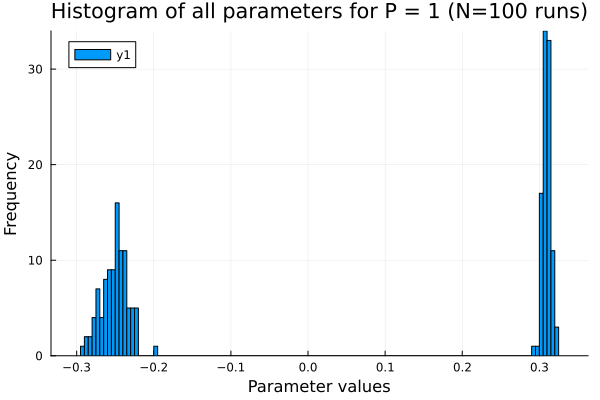

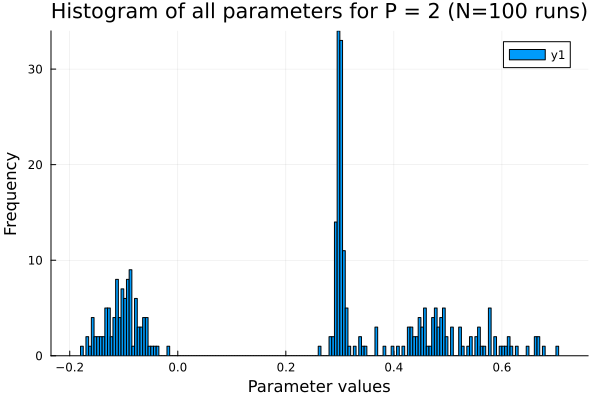

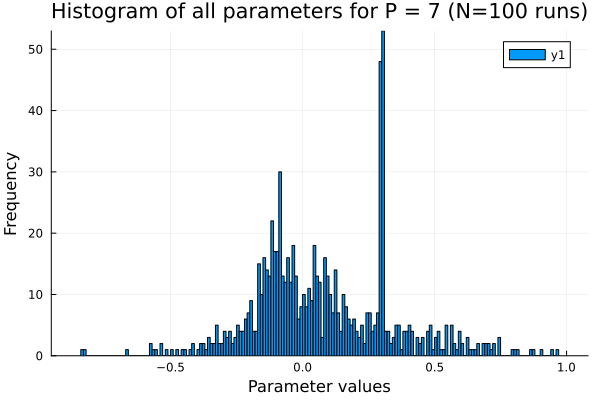

In [66]:
using Plots

reps = 100
pvals = [1, 2, 7]
map_estimates = Dict(p => [] for p in pvals)

for _ in 1:reps
    y = X * theta_true + sqrt(sigma_2) * randn(N)

    # Compute MAP estimates for each P value
    for p in pvals
        X_P = hcat(ones(N), [X_values .^ i for i in 1:p]...)
        map_estimate = compute_map_estimate(X_P, y, sigma_2)[1]

        push!(map_estimates[p], map_estimate)
    end
end

for p in pvals
    all_params = vcat(map_estimates[p]...)  # Flatten all parameter vectors into one big array

    histogram(
        all_params,
        bins=200,
        title="Histogram of all parameters for P = $p (N=$reps runs)",
        xlabel="Parameter values",
        ylabel="Frequency"
    )
    display(current())
end

The MAP histograms will be narrower than the ML histograms, especially for higher-order models. This is due to the shrinkage imposed by the prior, which regularizes the estimates and prevents them from becoming too large.

For higher-order models (like $P=7$), the MAP histograms will have less variance compared to the ML histograms. This is because the MAP estimation reduces overfitting by penalizing large parameter values through the prior.

The MAP estimates will generally be closer to the true values of the parameters, particularly for higher-order models. The histograms for MAP will be tightly centered around the true values, especially for $P=7$, while the ML histograms might show more deviation due to overfitting.

# Exercise 1.3

## 1.3 a


Finding the Likelihood $p(y \mid \boldsymbol{\theta})$

Given:
$$  
    \varepsilon = y - x \boldsymbol{\theta}
$$
where $\varepsilon \sim \mathcal{N}(0, \sigma^2 I)$, which implies that the likelihood is also Gaussian. Thus, the likelihood function is:
$$
    p(y \mid \boldsymbol{\theta}) = p(y - x\boldsymbol{\theta}) \sim \mathcal{N}(0, \sigma^2 I)
$$

For a single observation:
$$
    p(y \mid \boldsymbol{\theta}) = \frac{1}{(2\pi\sigma^2)^{N/2}} \exp \left( -\frac{1}{2\sigma^2} (y - x \boldsymbol{\theta})^T (y - x \boldsymbol{\theta}) \right)
$$

Assuming $N$ independent observations:
$$
    p(y \mid \boldsymbol{\theta}) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(y_i - x_i \boldsymbol{\theta})^2}{2\sigma^2} \right)
$$

or equivalently,
$$
    p(y \mid \boldsymbol{\theta}) \propto \exp \left( -\frac{1}{2\sigma^2} (y - x \boldsymbol{\theta})^T (y - x \boldsymbol{\theta}) \right)
$$

To find the log-likelihood, lets take the log of the derived likelihood equation:

$$
\ln p(y \mid \theta) = \sum_{i=1}^{N} \ln \left( \frac{1}{\sqrt{2\pi\sigma_i^2}} \right) + \sum_{i=1}^{N} \ln \left( \exp \left( -\frac{(y_i - x_i \theta)^2}{2\sigma_i^2} \right) \right)
$$
or equivalently,
$$
\ln p(y \mid \theta) = -\frac{N}{2} \ln (2\pi\sigma_i^2) - \sum_{i=1}^{N} \frac{(y_i - x_i \theta)^2}{2\sigma_i^2}
$$

## 1.3 b

The prior is Gaussian $p(\boldsymbol{\theta}) \sim \mathcal{N}(m_{\text{prior}}, \Sigma_{\text{prior}})$. Thus, the log-prior is

$$
    \ln p(\theta) = -\frac{1}{2} \ln (2\pi\sigma_p^2) - \frac{(\theta - \mu_p)^2}{2\sigma_p^2} \\
    \ln p(\theta) = -\frac{N}{2} \ln (2\pi\sigma_p^2) - \frac{1}{2\sigma_p^2} \theta^2 + \frac{\mu_p}{\sigma_p^2} \theta 
$$

Using Bayes' theorem:
$$
    p(\boldsymbol{\theta} \mid y) = \frac{p(y \mid \boldsymbol{\theta}) p(A)}{p(y)} 
$$

Since $p(y)$ does not depend on $\boldsymbol{\theta}$, we focus on the shape of the posterior:
$$
    \log p(\boldsymbol{\theta} \mid y) = \log p(y \mid \boldsymbol{\theta}) + \log p(\boldsymbol{\theta}) + C 
$$
where $C$ is a constant that we can ignore.

Plugging in the log-likelihood (from 1.3a) and log-prior, we are left with
$$
    \log p(\boldsymbol{\theta} \mid y) = -\frac{N}{2} \ln (2\pi\sigma_e^2) - \frac{N x^2}{2\sigma_e^2} \theta^2 + \frac{x \sum y_i}{\sigma_e^2} \theta
- \frac{1}{2} \ln (2\pi\sigma_p^2) - \frac{1}{2\sigma_p^2} \theta^2 + \frac{\mu_p}{\sigma_p^2} \theta
$$
We can ignore constants and terms that have no dependance on $\boldsymbol{\theta}$. Now, the posterior takes the form:
$$
    \log p(\boldsymbol{\theta} \mid y) = -\frac{N x^2}{2\sigma_e^2} \theta^2 + \frac{x \sum y_i}{\sigma_e^2} \theta - \frac{1}{2\sigma_p^2} (\theta^2 - 2 \mu_p \theta + \mu_p^2)
$$
$$
    \log p(\boldsymbol{\theta} \mid y) = -\frac{1}{2} \left( \frac{N x^2}{\sigma_e^2} + \frac{1}{\sigma_p^2} \right) \theta^2 + \left( \frac{x \sum y_i}{\sigma_e^2} + \frac{\mu_p}{\sigma_p^2} \right) \theta
$$

where:
$$
\sigma^2_{\text{post}} = \frac{1}{\frac{N x^2}{\sigma^2_e} + \frac{1}{\sigma^2_p}}
$$

$$
\mu_{\text{post}} = \frac{\frac{x \sum y_i}{\sigma^2_e} + \frac{\mu_p}{\sigma^2_p}}{\frac{N x^2}{\sigma^2_e} + \frac{1}{\sigma^2_p}}
$$

Since the posterior is a Gaussian distribution, it is fully specified by the above mean $\mu_{\text{post}}$ and covariance $\sigma^2_{\text{post}}$
